# ADA - Unsupervised learning

In [2]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs, make_moons
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

%matplotlib inline

# Part A) Tutorial

In this tutorial, you will learn how to discover clusters in data using Python.

Let's start by creating some **[synthetic](https://en.wikipedia.org/wiki/Synthetic_data)** data!
First, we create a super secret number that represents the number of the cluster to generate. 

Don't print it! We'll try to discover it automatically.

## K-Means

In [3]:
random.seed(42)
top_secret_number = random.randint(2, 10)

Now we can generate some data distributed in n groups:

In [4]:
total_samples = 100

# This create some artifical clusters with standard dev. = 2
X, _, centers = make_blobs(n_samples=total_samples,
                           centers=top_secret_number,
                           cluster_std=2,
                           n_features=2,
                           return_centers=True,
                           random_state=42)

X[:3]

array([[-8.57321463, -9.90980404],
       [ 6.26691327, -0.48855895],
       [-3.44814639, 10.09940622]])

Let's see how these clusters look like and where is their center:

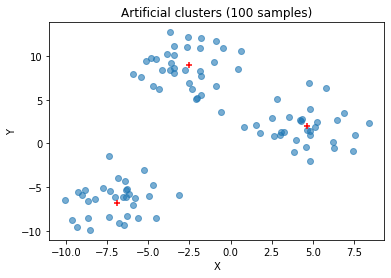

In [5]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Artificial clusters (%s samples)" % total_samples)

for c in centers:
    plt.scatter(c[0], c[1], marker="+", color="red")

### Clustering the data
How many clusters do you see? Probably easy for a human, but not so trivial for a computer. 

Let's try to group the data with K-Means. Recall that K-Means requires you to specify the number of clusters (K). Let's start by testing multiple values between 2 and 10:

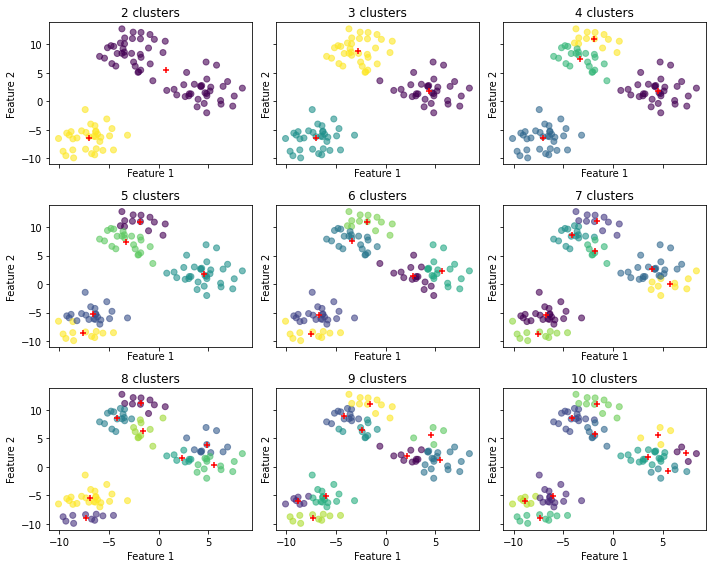

In [6]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

# Compute number of row and columns
COLUMNS = 3
ROWS = math.ceil((MAX_CLUSTERS - MIN_CLUSTERS) / COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10, 8), sharey=True, sharex=True)

# Plot the clusters
for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS + 1):
    current_column = (n_clusters - MIN_CLUSTERS) % COLUMNS
    current_row = (n_clusters - MIN_CLUSTERS) // COLUMNS
    # Get the axis where to add the plot
    ax = axs[current_row, current_column]
    # Cluster the data with the current number of clusters
    kmean = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    # Plot the data by using the labels as color
    ax.scatter(X[:, 0], X[:, 1], c=kmean.labels_, alpha=0.6)
    ax.set_title("%s clusters" % n_clusters)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    # Plot the centroids
    for c in kmean.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

### Bonus example: 
Did you know you can animate your plots?

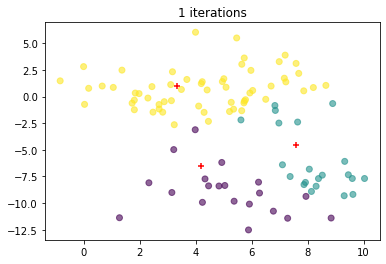

In [7]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

X_3clusters, _, centers = make_blobs(n_samples=100,
                                     centers=3,
                                     cluster_std=2,
                                     return_centers=True,
                                     random_state=99)


# Update frame callback
def update(max_iter):
    # Clean the plot
    plt.clf()
    plt.cla()
    # Cluster and get the labels
    kmeans = KMeans(n_clusters=3,
                    init="random",
                    algorithm="full",
                    random_state=10,
                    n_init=1, max_iter=max_iter).fit(X_3clusters)
    # Plot
    plt.scatter(X_3clusters[:, 0], X_3clusters[:, 1], c=kmeans.labels_, alpha=0.6)
    for c in kmeans.cluster_centers_:
        plt.scatter(c[0], c[1], marker="+", color="red")
    plt.title("%s iterations" % max_iter)


# Animate 1 frame per second
anim = FuncAnimation(fig, update, frames=np.arange(1, 20), interval=500)

# Save the gif
anim.save('clusters.gif', dpi=80)

### How to select K in K-Means?

You have a couple of options:
- Silhouette score: Find the K with the desired tradeoff between the number of clusters and cohesion/separation.
- Elbow method: Find the "elbow" in the curve of the Sum of Squared Errors

Let's see what we can observe using these 2 methods.

#### Silhouette score

To generate the curve of the silhouette score, we cluster the data with different value of K and plot the resulting values.

Text(0, 0.5, 'Silhouette score')

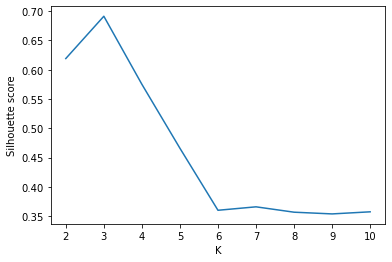

In [8]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(X)
    # Get the Silhouette score
    score = silhouette_score(X, labels)
    silhouettes.append({"k": k, "score": score})

# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

#### Elbow method

Similarly yo the previous case, we compute the SSE for different values of K, and we plot the distribution:

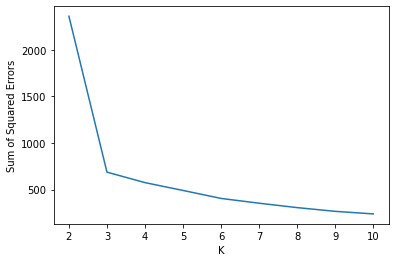

In [9]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")


plot_sse(X)

Using the two methods, we get different recommendations. Silhouette suggests that using 3 clusters is a fair tradeoff between the number of groups and their separation. The elbow method shows how the SSE reduction is less significant with more than 3 clusters.

Let's plot the best clusters:

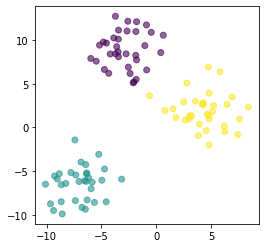

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4), sharey=True)

# Plot the clusters with K = 3
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X)
axs.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.6)


Ultimately it is up to you (domain expert!) to pick the number of clusters that better represent the data.

The best representation, in this case, is obtained with k = 3.

-----

### Visualizing high dimensional data

Visualizing 2-dimensional data is easy, but what happens when we have more than three features? 

We can use dimensionality reduction techniques! Let start by generating some artifical clusters with 10 features. 
We use the same number of samples and groups as the previous example:

In [11]:
total_samples = 100

# This create some artifical clusters with standard dev. = 3
X10d, _ = make_blobs(n_samples=total_samples,
                     centers=top_secret_number,
                     cluster_std=3,
                     n_features=10,
                     random_state=0)

print("The features of the first sample are: %s" % X10d[0])

The features of the first sample are: [ 7.05933272  4.20962197 -2.77357361  6.59147131 -6.64440614  9.47625342
 -3.01996723  7.36384861  1.41157528  1.28459274]


To transform this features vector in a form that can be represented in a simple plot, we can reduce the number of dimensions by preserving as much information as possible. Let's see two techniques that can help in this task:

- t-SNE
- PCA


Note: the next lecture will cover more theoretical aspects of these methods.

In [12]:
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(X10d)

print("The features of the first sample are: %s" % X_reduced_tsne[0])

/home/user72/miniconda3/envs/adaexam/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/user72/miniconda3/envs/adaexam/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The features of the first sample are: [-2.981578  4.051194]


In [13]:
X_reduced_pca = PCA(n_components=2).fit(X10d).transform(X10d)

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [-6.17922102  7.01618025]


The features are reduced in both cases to a 2d space. Please note that they are not the same because the two techniques optimize different objectives.

Text(0.5, 1.0, 'PCA')

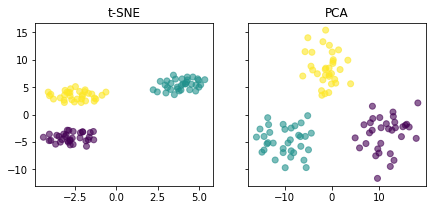

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# Cluster the data in 3 groups
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X10d)

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=labels, alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=labels, alpha=0.6)
axs[1].set_title("PCA")

### Density based: DBSCAN

K-Means is an intuitive and effective algorithm, but what happens when the data has a complex shape?

As for the previous example, let's generate some synthetic data that resemble two half-moons.

Text(0, 0.5, 'Feature 2')

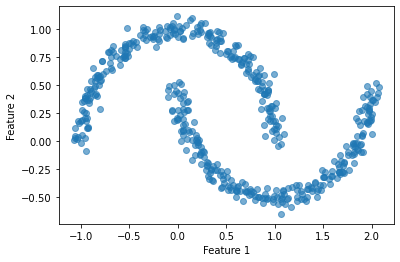

In [15]:
# Create 500 random points with 2-moons shape
X_moons, _ = make_moons(500, noise=0.05, random_state=0)

plt.scatter(X_moons[:, 0], X_moons[:, 1], alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

We can visually see that there are two groups. Let's assign the labels with K-Means!

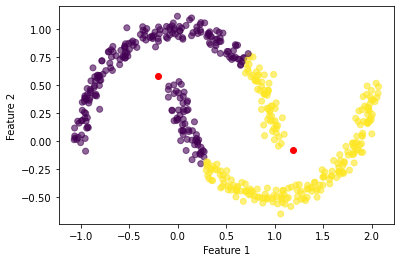

In [16]:
kmean = KMeans(n_clusters=2, random_state=0).fit(X_moons)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=kmean.labels_, alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot the centroids
for c in kmean.cluster_centers_:
    plt.scatter(c[0], c[1], marker="o", color="red")

Let's cluster the data with DBSCAN by variating the `eps` value in the range between 0.05 and 0.15.

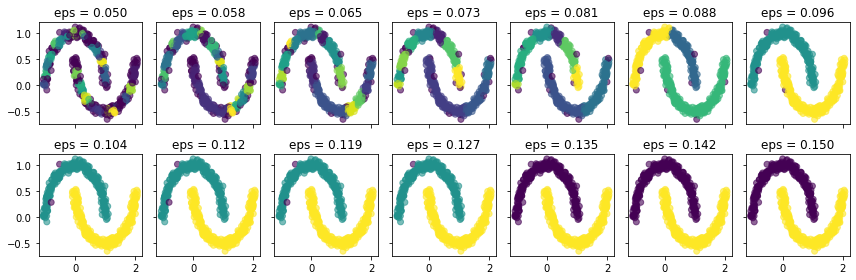

In [17]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list) / COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]

    current_column = i % COLUMNS
    current_row = i // COLUMNS

    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(X_moons)
    ax.scatter(X_moons[:, 0], X_moons[:, 1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))

plt.tight_layout()

-------
# Part B: Exercises

## Exercise 1. Real world data! Wheat has a kernel too!


<img src="img/wheat_banner.png" width="800">

Data Set Information:

> The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

Source: https://archive.ics.uci.edu/ml/datasets/seeds



In [35]:
seeds = pd.read_csv("seeds_dataset.csv")
seeds.sample(10)

,ID,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
103,104,19.18,16.63,0.8717,6.369,3.681,3.357,6.229,2
54,55,14.52,14.60,0.8557,5.741,3.113,1.481,5.487,1
86,87,18.88,16.26,0.8969,6.084,3.764,1.649,6.109,2
154,155,11.36,13.05,0.8382,5.175,2.755,4.048,5.263,3
170,171,11.02,13.00,0.8189,5.325,2.701,6.735,5.163,3
25,26,16.19,15.16,0.8849,5.833,3.421,0.903,5.307,1
178,179,11.48,13.05,0.8473,5.180,2.758,5.876,5.002,3
142,143,13.34,13.95,0.8620,5.389,3.074,5.995,5.307,3
164,165,11.14,12.79,0.8558,5.011,2.794,6.388,5.049,3
162,163,12.05,13.41,0.8416,5.267,2.847,4.988,5.046,3


In [36]:
seeds.describe()

,ID,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,105.500000,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,60.765944,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,1.000000,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,53.250000,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,105.500000,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,157.750000,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,210.000000,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In this exercise, we are interested in discovering structure in the data by hiding the actual label provided in the dataset.

### Question 1.1: Prepare the dataset

- Create a dataset by keeping only the meaningful features. Remove the type.
- Plot the histogram of the different features.
- The features have different scales, but we want to give the same importance to all them. Find a way to mitigate the problem.

In [37]:
df = seeds.drop(["ID", "seedType"], axis=1)
df.sample(10)

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
60,11.42,12.86,0.8683,5.008,2.850,2.700,4.607
165,12.10,13.15,0.8793,5.105,2.941,2.201,5.056
178,11.48,13.05,0.8473,5.180,2.758,5.876,5.002
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219
168,11.35,13.12,0.8291,5.176,2.668,4.337,5.132
171,11.55,13.10,0.8455,5.167,2.845,6.715,4.956
161,12.02,13.33,0.8503,5.350,2.810,4.271,5.308
9,16.44,15.25,0.8880,5.884,3.505,1.969,5.533
10,15.26,14.85,0.8696,5.714,3.242,4.543,5.314
50,14.43,14.40,0.8751,5.585,3.272,3.975,5.144


In [38]:
df.isna().sum().sum()

0

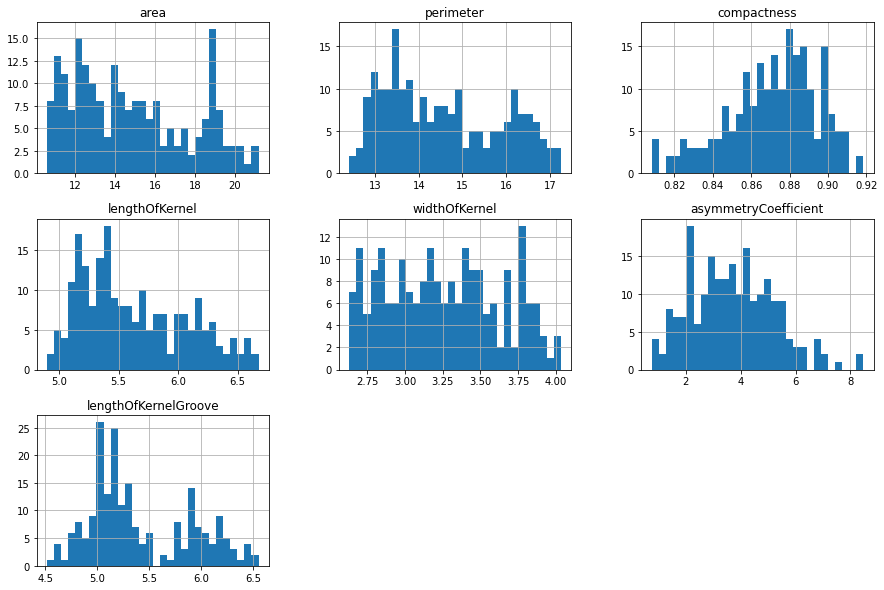

In [39]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

In [40]:
# standardize to make the scales of different features comparable
df = (df - df.mean()) / df.std()
assert np.allclose(df.mean(), 0)
assert np.allclose(df.std(), 1)

df.sample(10)

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
111,1.557713,1.654504,0.025453,1.522280,1.409518,-0.014766,1.133165
155,-1.257011,-1.155692,-1.933970,-0.854355,-1.545095,1.405200,-0.384698
109,1.272460,1.271644,0.656022,1.183728,1.099760,-1.305039,0.988704
117,1.478667,1.447760,0.761823,1.391373,1.473058,-0.409829,1.580792
99,1.330885,1.363530,0.423262,1.332691,1.126235,-1.005749,1.401741
104,1.409931,1.424788,0.503670,1.398144,1.314208,-0.220943,1.505510
91,1.344632,1.256329,1.159632,1.226611,1.422755,-0.385886,1.312216
94,1.207161,1.501360,-1.091799,2.341576,0.599382,0.819922,2.115910
174,-1.380735,-1.224607,-2.585700,-0.791158,-1.635110,0.985529,-0.453876
119,1.781104,1.792334,0.427494,1.951112,1.584253,-0.423796,1.855473


### Question 1.2: Cluster the data with K-Means

- Use the Elbow method to find the best value of K

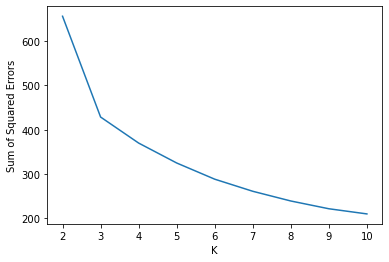

In [41]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")


plot_sse(df)

**Comment:**

Elbow method says 3.

---

### Question 1.3: Visualise your clusters

- Use t-SNE to plot your clusters
- Compare side by side 2 plots using the original labels (seedType) and the ones generated by K-Means.

/home/user72/miniconda3/envs/adaexam/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/user72/miniconda3/envs/adaexam/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


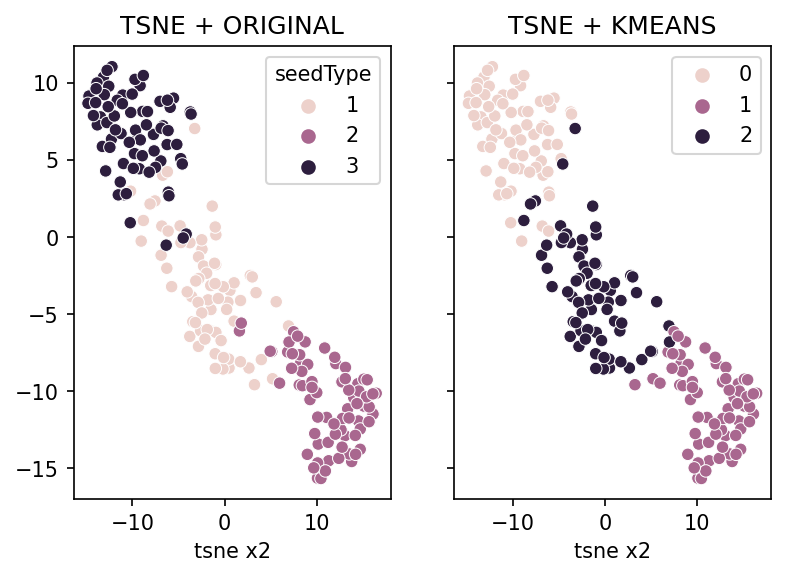

In [42]:
import seaborn as sns

kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
tsne = TSNE(n_components=2, random_state=0).fit(df)

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, sharey=True, sharex=True)

for labels, title, ax in [
    (seeds["seedType"], "TSNE + ORIGINAL", ax1),
    (kmeans.labels_, "TSNE + KMEANS", ax2)
]:
    ax.set_title(title)
    ax.set_xlabel("tsne x1")
    ax.set_xlabel("tsne x2")
    sns.scatterplot(x=tsne.embedding_[:, 0], y=tsne.embedding_[:, 1], hue=labels, ax=ax)

plt.show()

# Exercise 2. Real world data! More examples with Wine

> These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

Source: https://archive.ics.uci.edu/ml/datasets/wine

### Question 2.1: Assign the wine to its group

In this dataset the label is missing. Repeat the previous analysis to assign the wine to its original group.

- Select the reasonable number of clusters
- Plot the data

In [26]:
wine = pd.read_csv("wine-clustering.csv")
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [27]:
# 1. na?
wine.isna().sum().sum()

0

In [28]:
# 2. standardize
wine = (wine - wine.mean()) / wine.std()
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767


Relevant elbow is at three


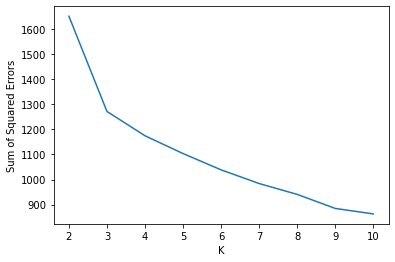

In [29]:
# 3. elbow method for kmeans
plot_sse(wine)
print("Relevant elbow is at three")

/home/user72/miniconda3/envs/adaexam/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


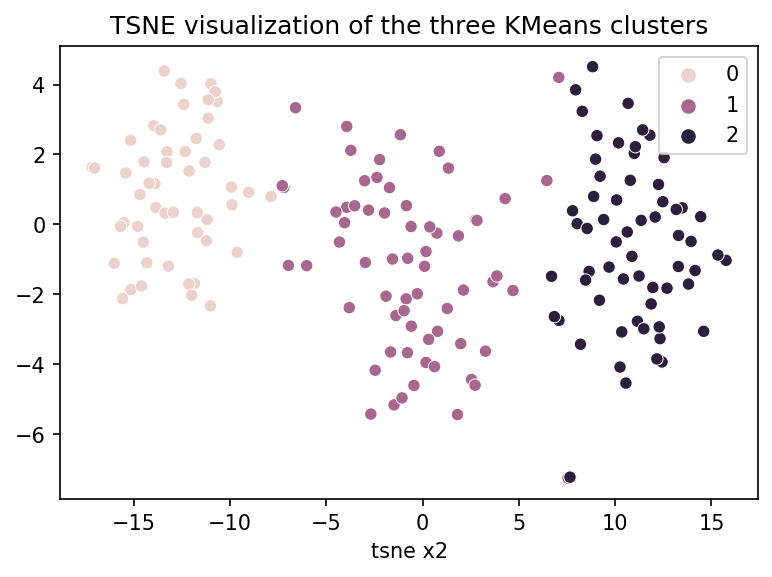

In [30]:
# 4. Visualize using TSNE
df = wine
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
tsne = TSNE(n_components=2, learning_rate="auto", random_state=0, init="pca").fit(df)

fig = plt.figure(dpi=150)
ax = fig.gca()
ax.set_title("TSNE visualization of the three KMeans clusters")
ax.set_xlabel("tsne x1")
ax.set_xlabel("tsne x2")
sns.scatterplot(x=tsne.embedding_[:, 0], y=tsne.embedding_[:, 1], hue=kmeans.labels_, ax=ax)
plt.show()

In [31]:
# 5. sell the labels and make cash
labels = kmeans.labels_
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


---------
# Part C: Quiz

### Question 1: Which of the following real-world ML applications is not unsupervised learning?
1. Netflix matrix factorization pipeline to discover users with similar interests
2. Speaker recognition (recognition of the identity of who is talking) in phones and smart assistant devices
3. LDA topic modeling on Twitter content to discover customers' opinions about a product
4. K-means clustering of Web domains 


In [32]:
"2."

'2.'

### Question 2: Which of the following is true for the k-means clustering algorithm?

1. It always converges to a global optimum.
2. In each iteration, points are assigned to the closest centroid and the new centroids are recomputed.
3. It outputs the optimal number of clusters.
4. None of the above.

In [33]:
"2."

'2.'